# Data Boycott and Data Strikes: Simulated Campaign Results

## Goals of this notebook
This notebook includes code for exploring the results of simulated boycotts. It also generates plots (for papers/presentations). This notebook covers 3 broad categories of experiments

1. MovieLens 1M random boycotts
2. MovieLens 1M homogeneous boycotts (e.g. fans of Comedy movies boycott together, people of a single age group boycott together)
3. MovieLens 20M random boycotts



In [1]:
import viz_constants 
import importlib

# slightly annoying reload hack
# see https://support.enthought.com/hc/en-us/articles/204469240-Jupyter-IPython-After-editing-a-module-changes-are-not-effective-without-kernel-restart
importlib.reload(viz_constants)
(
    num_users, num_ratings
) = (
    viz_constants.num_users, viz_constants.num_ratings
)

In [2]:
from collections import defaultdict, OrderedDict
import json
from pprint import pprint

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="darkgrid")
sns.set_color_codes("dark")

from scipy import stats
from scipy.interpolate import interp1d

# http://files.grouplens.org/datasets/movielens/ml-20m-README.txt


for dataset in ['ml-20m', 'ml-1m']:
    ratio = num_ratings[dataset] / num_users[dataset]
    print(dataset, ratio)

ml-20m 144.4135299257002
ml-1m 165.5975165562914


First things first: let's load our master data files. Each is a single csv that was created by the `process_all.py` script.

In [3]:
df_1m = pd.read_csv('ml-1m_collected_10_28/all_results.csv', dtype={'indices': str})
df_1m = df_1m[df_1m.ratingfrac.notna()]
df_1m['dataset'] = 'ml-1m'

In [4]:
df_20m = pd.read_csv('ml-20m_collected_11_01/all_results.csv', dtype={'indices': str})
df_20m = df_20m[df_20m.ratingfrac.notna()]
df_20m['dataset'] = 'ml-20m'

Now we apply transformation that will affect the entire dataframe.
1. Calculate the number of users included in each experiment.
2. Calculate the number of ratings missing per experiment (so we can estimate how much we'd "expect" performance to decrease)
3. Calculate the number of ratings missing per experiment, rounded to the nearest 10^5

In [5]:
for df, dataset in [
    (df_1m, 'ml-1m',),
    (df_20m, 'ml-20m',),
]:
    # Whoops! Assign doesn't work in a for loop.
#     df = df.assign(num_users_boycotting = [(NUM_USERS - int(x))/NUM_USERS for x in df.num_users])
#     df = df.assign(num_ratings_missing = [NUM_RATINGS - int(x) for x in df.num_ratings])
#     df = df.assign(nrm_rounded = [round(x, -5) for x in df.num_ratings_missing])
    filename_ratingcv_standards = 'standard_results/{}_ratingcv_standards_for_{}.json'.format(
        dataset, 'GlobalMean')
    with open(filename_ratingcv_standards, 'r') as f:
        global_mean_res = json.load(f)
        
    filename_ratingcv_standards = 'standard_results/{}_ratingcv_standards_for_{}.json'.format(
        dataset, 'SVD')
    with open(filename_ratingcv_standards, 'r') as f:
        svd_res = json.load(f)
    
    df['num_users_boycotting'] = [(num_users[dataset] - int(x)) / num_users[dataset] for x in df.num_users]
    df['num_ratings_missing'] = [num_ratings[dataset] - int(x) for x in df.num_ratings]
    df['nrm_rounded'] = [round(x, -5) for x in df.num_ratings_missing]
    
    #  handle 'surfaced-hits'
    try:
        new_metric = 'surfaced-hits'
        for group in ['all', 'non-boycott', 'like-boycott']:
            denom = (svd_res['hits'] / svd_res['normhits'] * num_users[dataset])
            # Want to see the # hits per run, # users, and # ideal hits?
            print(svd_res['hits'], num_users[dataset], denom)

            # just divide totalhits by # ideal hits (total # ratings / # folds) 
            for a in [
                '',
                'increase_',
                'standards_',
            ]:
                key = a + new_metric + '_' + group
                print(key)
                df[key] = [x / denom for x in df[a + 'totalhits_' + group]]
            
        # handle 'not-like-boycott' group
        other = 'totalhits'
        for x in [
            other,
            'standards_' + other,
            'increase_' + other,
            new_metric,
            'standards_' + new_metric,
            'increase_' + new_metric,
        ]:
            df[x + '_not-like-boycott'] = df[x + '_non-boycott'] - df[x + '_like-boycott']
        
        
        df['percent_increase_' + other + '_not-like-boycott'] = 100 * (
            df['increase_' + other + '_not-like-boycott']
        ) / df['standards_' + other + '_not-like-boycott']
        
        for group in ['all', 'non-boycott', 'like-boycott']:
            df['percent_increase_' + new_metric + '_' + group] = 100 * (
                df['increase_' + new_metric + '_' + group]
            ) / df['standards_' + new_metric + '_' + group]
        
    except KeyError as err:
        #raise
        print('Skipping', dataset)
        print(err)
    

    # drop columns we're not going to use.
    drops = [
        #'tail',
        # 'vanilla',
    ]
    for column in df.columns.values:
        for drop in drops:
            if drop in column:
                df = df.drop(column, axis=1)

14.75632421589539 6040 117370.03696488823
surfaced-hits_all
increase_surfaced-hits_all
standards_surfaced-hits_all
14.75632421589539 6040 117370.03696488823
surfaced-hits_non-boycott
increase_surfaced-hits_non-boycott
standards_surfaced-hits_non-boycott
14.75632421589539 6040 117370.03696488823
surfaced-hits_like-boycott
increase_surfaced-hits_like-boycott
standards_surfaced-hits_like-boycott
10.901500402382888 138493 2068444.9883455127
surfaced-hits_all
increase_surfaced-hits_all
standards_surfaced-hits_all
10.901500402382888 138493 2068444.9883455127
surfaced-hits_non-boycott
increase_surfaced-hits_non-boycott
standards_surfaced-hits_non-boycott
10.901500402382888 138493 2068444.9883455127
surfaced-hits_like-boycott
Skipping ml-20m
'totalhits_like-boycott'


# EDIT ME
Define all the lists that can be used throughout. By editing this cell we can easily modify the full notebook.

In [6]:
id_vars = ['name','algo_name', 'indices', 'ratingfrac', 'userfrac', 'num_ratings', 'num_users', 'num_users_boycotting']
#id_vars = [x for x in id_vars if x in list(df.columns.values)]
metrics = [
    'rmse',
    'ndcg10',
    #'tailndcg10',
    #'ndcg5',
    #'tailndcg5',
    'ndcgfull',
    #'tailndcgfull',
    #'ndcgfull',
    'prec10t4',
    #'tailprec10t4',
    #'prec5t4',
    #'tailprec5t4',
    'hits',
    'totalhits',
    'normhits',
]

organized_experiments = [
    'gender', 'state', 'power', 'genre', 'occupation', 'age'
]
algo_names = [
    #'KNNBaseline_item_msd',
    'SVD'
]
standard_algo_names = [
    'SVD', 
    'GlobalMean', 
    #'GuessThree',
    'MovieMean', 
    'KNNBaseline_item_msd',
    'KNNBasic_user_msd',
    'KNNBasic_item_msd',
]

# Flags
A variety of flags to turn various analyses on or off. Turning more flags off will make the notebook run faster.

In [7]:
flags = {}

## Load and Organize Standard Results
For any of our visualizations to be meaningful, we need standard results to compare the boycott results to. These standards let us evaluate "what is the effect of the boycott compared to other algorithms".

In particular, we compare the boycott performance to performance when using very non-personalized algorithms (MovieMean) and simpler personalized algorithms (user-based KNN, item-based KNN).

Below, we load these results from json files into Python data structures so we can use below when generating plots.

In [8]:
dataset_to_algo_to_metric_to_altalgo = {}
ds2standards = {}

one_mill_svd = {}
for dataset in [
    'ml-1m',
    'ml-20m',
]:
    standard_results = {}
    algo2metric2altalgo = defaultdict(lambda: defaultdict(dict))

    for algo_name in standard_algo_names:
        try:
            filename_ratingcv_standards = 'standard_results/{}_ratingcv_standards_for_{}.json'.format(
                dataset, algo_name)
            with open(filename_ratingcv_standards, 'r') as f:
                standard_results[algo_name] = json.load(f)
                if algo_name == 'SVD' and dataset == 'ml-1m':
                    one_mill_svd = standard_results[algo_name]
        except FileNotFoundError:
            print('File not found: {}'.format(filename_ratingcv_standards))
    for main_algo_name in algo_names:
        for metric in metrics:
            goodval = standard_results[main_algo_name].get(metric, 0)
            for st_algo_name in standard_algo_names:
                val = standard_results.get(st_algo_name, {}).get(metric)
                if val:
                    algo2metric2altalgo[main_algo_name][metric][st_algo_name] = (val - goodval) / goodval * 100 if goodval else 0
                else:
                    algo2metric2altalgo[main_algo_name][metric][st_algo_name] = 0
                if metric == 'normhits':

                    denom = (standard_results['SVD']['hits'] / standard_results['SVD']['normhits'] * num_users[dataset])
                    print(st_algo_name)
                    # since user isn't computed for 20m
                    
                    if st_algo_name in standard_results:
                        goodval = standard_results[st_algo_name].get('totalhits', 0) / denom
                        standard_results[st_algo_name]['surfaced-hits'] = goodval
                        
                        algo2metric2altalgo[main_algo_name]['surfaced-hits'][st_algo_name] = algo2metric2altalgo[
                            main_algo_name]['totalhits'][
                            st_algo_name
                        ]
                        #algo2metric2altalgo[main_algo_name]['surfaced-hits'][st_algo_name] = (val - goodval) / goodval * 100 if goodval else 0
            if dataset == 'ml-20m':
                val = one_mill_svd.get(metric)
                if val:
                    algo2metric2altalgo[main_algo_name][metric]['1M_SVD'] = (val - goodval) / goodval * 100 if goodval else 0
                else:
                    algo2metric2altalgo[main_algo_name][metric]['1M_SVD'] = 0
            
            
    dataset_to_algo_to_metric_to_altalgo[dataset] = algo2metric2altalgo
    ds2standards[dataset] = standard_results
pprint(dataset_to_algo_to_metric_to_altalgo)
#pprint(ds2standards)

SVD
GlobalMean
MovieMean
KNNBaseline_item_msd
KNNBasic_user_msd
KNNBasic_item_msd
File not found: standard_results/ml-20m_ratingcv_standards_for_KNNBasic_user_msd.json
SVD
GlobalMean
MovieMean
KNNBaseline_item_msd
KNNBasic_user_msd
KNNBasic_item_msd
{'ml-1m': defaultdict(<function <lambda> at 0x000001A9DB32EC80>,
                      {'SVD': defaultdict(<class 'dict'>,
                                          {'hits': {'GlobalMean': -17.84257427465695,
                                                    'KNNBaseline_item_msd': -0.7099847926533698,
                                                    'KNNBasic_item_msd': -1.1160692641802905,
                                                    'KNNBasic_user_msd': -0.9222335324425183,
                                                    'MovieMean': -1.8152304579426788,
                                                    'SVD': 0.0},
                                           'ndcg10': {'GlobalMean': -25.473630285204873,
                

# Estimate change in "hits" based on precision or ndcg

For a given list of k-items, we assume users will click the items in that list that are "good" (rating over 4).


One way to do this is to follow this linear model:

* a user who gets a list with "full precision" (i.e. SVD w/ full data) provides 5 hits
* a user who gets a list with "un-personalized precision" (i.e. MovieMean) provides 5/ratio hits!
* note that in this case even users w/ bad lists still provide hits

Using these two points, we fit a line:


When ratio=1, recommender adds NO VALUE and therefore strikes do NO DAMAGE!

Anchor:hits

In [9]:
normalize_hits = False

for df, dataset in [
    (df_1m, 'ml-1m',),
    (df_20m, 'ml-20m',),
]:
    metric2altalgo = dataset_to_algo_to_metric_to_altalgo[dataset]['SVD']
    # will only work for SVD as its written right now.
    
    #personalization_boost_coefficient
    for pbc in [
        1.1, 1.02, 2, 4, 8,
    ]:
        for old_metric, k in [
            ('prec10t4', 10),
            #('ndcg10', 10),
            # the actual count of 4 star ratings in the whole ds
            ('hits', 1),
            ('totalhits', 1),
            ('normhits', 1)
        ]:
            for group in ['non-boycott', 'all']:
                # name the new dataframe column
                new_metric = '{}boosthits-{}'.format(pbc, old_metric)
                total_possible_hits = num_users[dataset] * k
                if old_metric == 'totalhits':
                    total_possible_hits = ds2standards[dataset]['SVD'][old_metric]
                elif old_metric == 'hits':
                    total_possible_hits = ds2standards[dataset]['SVD'][old_metric] * num_users[dataset]
                
                # boycotting users provide 0 hits. 
                # so with a full boycott, damage = total possible hits
                comparison = -1 * total_possible_hits
                #comparison = -1 * ds2standards[dataset]['SVD'][old_metric] * total_possible_hits

                key_template = 'percent_increase_{}_{}'
                new_key = key_template.format(new_metric, group)

   
                # no missing users in a strike ("All Users" perspective)
                if group == 'all':
                    frac_miss_arr = [0] * len(df.index)
                # there are missing users in a data boycott!
                else:
                    frac_miss_arr = list(df['num_users_boycotting'])

                labor_metric = 'labor-' + new_metric
                consumer_metric = 'consumer-' + new_metric

                # get the predicted diff if we switched to MovieMean
                pred_diff = metric2altalgo[old_metric]['MovieMean']
                # should get more negative as prec_val gets more negative
                #print(pred_diff)
                coefficients = np.polyfit(
                    [pred_diff, 0], # x values
                    [total_possible_hits/pbc - total_possible_hits, 0],# y values
                    1, # polynomial order, i.e. this is a line
                )

                df[key_template.format(labor_metric, group)] = [
                    ( coefficients[1] + coefficients[0] * prec_val  * (1 - frac_miss)) for (
                        prec_val, frac_miss
                    ) in zip(df[key_template.format(old_metric, group)], frac_miss_arr)
                ]
                df[key_template.format(consumer_metric, group)] = [
                    (comparison * frac_miss) for frac_miss in frac_miss_arr
                ]

                df[new_key] = [
                    (labor_power + consumer_power) for (
                        labor_power, consumer_power
                    ) in zip(
                        df[key_template.format('labor-' + new_metric, group)],
                        df[key_template.format('consumer-' + new_metric, group)],
                    )
                ]
                df[new_key.replace('percent_increase_', '')] = [
                    (labor_power + consumer_power + ds2standards[dataset]['SVD']['totalhits']) for (
                        labor_power, consumer_power
                    ) in zip(
                        df[key_template.format('labor-' + new_metric, group)],
                        df[key_template.format('consumer-' + new_metric, group)],
                    )
                ]

                if normalize_hits:
                    print('Normalizing. Will divide hit values by total possible hits.')
                    df[new_key] /= total_possible_hits
                    df[key_template.format(labor_metric, group)] /= total_possible_hits
                    df[key_template.format(consumer_metric, group)] /= total_possible_hits

                for st_al_nm in standard_algo_names:
                    old_val = metric2altalgo[old_metric][st_al_nm]
                    # convert from percent to raw precision change
                    old_val *= ds2standards[dataset]['SVD'][old_metric] / 100
                    # multiply by k and the probability of clicks b/c we want to get from prec@5 to hits
                    if not normalize_hits:
                        old_val *= total_possible_hits
                    metric2altalgo[new_metric][st_al_nm] = old_val
                    metric2altalgo[labor_metric][st_al_nm] = old_val
                    metric2altalgo[consumer_metric][st_al_nm] = old_val
            df['increase_hit-ratio@{}_non-boycott'.format(k)] = [
                boycott_val / strike_val for (boycott_val, strike_val) in zip(
                    df[key_template.format(new_metric, 'non-boycott')], df[key_template.format(new_metric, 'all')])
            ]
            df['increase_hit-ratio@{}_all'.format(k)] = [
                boycott_val / strike_val for (boycott_val, strike_val) in zip(
                    df[key_template.format(new_metric, 'non-boycott')], df[key_template.format(new_metric, 'all')])
            ]
            #print(df[['num_users_boycotting', 'increase_hits-prec5t4_non-boycott', 'increase_hits-prec5t4_all', 'increase_hit-ratio@5_non-boycott']])


## Seperate out our data
We want to separate the simuated boycotts into homogenous vs. heterogenous boycotts.

In [10]:
samples_df_20m = df_20m[df_20m['type'] == 'sample_users']
print('\n===Heterogenous 20M Boycotts===\n')
print(samples_df_20m.name.value_counts())
samples_df_1m = df_1m[df_1m['type'] == 'sample_users']
print('\n===Heterogenous Boycotts===\n')
print(samples_df_1m.name.value_counts())
org_df = df_1m[df_1m['type'].isin(organized_experiments)]
print('\n===Homogenous Boycotts===\n')
print(org_df.name.value_counts())


===Heterogenous 20M Boycotts===

1385 user sample      65
6925 user sample      65
692 user sample       65
138 user sample       65
69 user sample        65
14 user sample        60
27699 user sample     40
41548 user sample     40
13849 user sample     40
55397 user sample     40
96945 user sample     40
110794 user sample    40
137108 user sample    40
124644 user sample    40
69246 user sample     40
83096 user sample     40
Name: name, dtype: int64

===Heterogenous Boycotts===

60 user sample      250
6 user sample       250
3 user sample       250
3020 user sample    250
5436 user sample    250
1812 user sample    250
2416 user sample    250
1208 user sample    250
4228 user sample    250
1 user sample       250
30 user sample      250
3624 user sample    250
4832 user sample    250
604 user sample     250
302 user sample     250
5980 user sample    250
Name: name, dtype: int64

===Homogenous Boycotts===

male users excluded                               50
Bottom 10% contributo

# Compare Precision-Estimated Hits to Actual Hits


   num_users_boycotting    variable     value
0                   0.2  ndcg10_all  0.787265
1                   0.2  ndcg10_all  0.787250
2                   0.2  ndcg10_all  0.785957
3                   0.2  ndcg10_all  0.786934
4                   0.2  ndcg10_all  0.785387


C:\Users\Nick\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


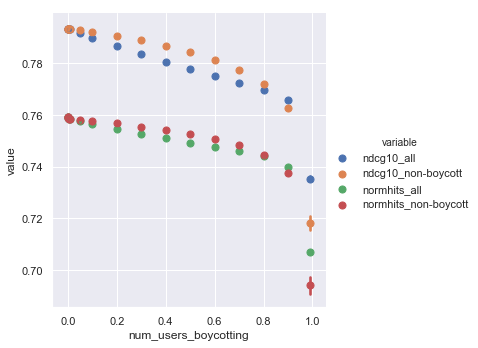

In [11]:
hits_df = samples_df_1m.copy()
hits_df = hits_df[~hits_df.hits_all.isna()]
hits_metric = 'ndcg10'
metric2 = 'normhits'
include = [
    'num_users_boycotting', 
]
hits_cols = [
    '{}_all'.format(hits_metric), 
    '{}_non-boycott'.format(hits_metric),
    #'{}_boycott'.format(hits_metric),
]
# for col in hits_cols:
#     hits_df[col] *= 0.76 / 14.75#num_users['ml-1m']

plot_metric2 = True
include += hits_cols
if plot_metric2:
    cols = [
        '{}_all'.format(metric2), 
        '{}_non-boycott'.format(metric2),
    ]

    include += cols
    
hits_df = hits_df[include].melt(id_vars='num_users_boycotting')
print(hits_df.head())

# for k in hits_df.num_users_boycotting:
#     print(k)
#     matches_from_hits = hits_df[hits_df.num_users_boycotting == k]
#     matches_from_orig = samples_df_1m[hits_df.num_users_boycotting == k]

sns.lmplot(
        x="num_users_boycotting", y="value", hue='variable', data=hits_df,
        fit_reg=False,
        x_estimator=np.mean, ci=99, 
    )
plt.show()

In [12]:
from collections import defaultdict
name2vals = defaultdict(list)

for name, group in hits_df.groupby('num_users_boycotting'):
    #print(name)
    for subname, subgroup in group.groupby('variable'):
        #print(subname, subgroup['value'].mean())
        name2vals[subname].append(subgroup['value'].mean())
        
print(name2vals)

defaultdict(<class 'list'>, {'ndcg10_all': [0.7931250310896443, 0.7932713480025121, 0.7933384022023857, 0.7933118726742144, 0.7931513379318039, 0.7916711566486403, 0.7899893463109552, 0.7866861150073696, 0.7835196822674622, 0.7805176549803142, 0.7776396328406548, 0.7749214288544028, 0.7723996797486925, 0.7696992468304245, 0.7658600080020406, 0.7354183693266847], 'ndcg10_non-boycott': [0.7931275276641484, 0.7932797634204442, 0.7933561219656592, 0.7934163494733748, 0.793370163372054, 0.7927533890869488, 0.79205360787687, 0.7905728712441638, 0.7889011616093675, 0.7868481634529079, 0.7842452463726403, 0.7812693033980893, 0.7774655702733646, 0.7719522481723987, 0.7625499535674835, 0.7182904912395457], 'normhits_all': [0.7591481177386741, 0.7590574816292169, 0.7588924310552186, 0.7585775032894058, 0.758432497789692, 0.7575709076012412, 0.7565830980270858, 0.7547139516992252, 0.7527810822611931, 0.7510419907082321, 0.7493408319453282, 0.7476833966064055, 0.7460579473660366, 0.7439874267753422

ndcg10_all normhits_all
(0.9842313247370235, 6.235479069629971e-12)
ndcg10_non-boycott normhits_non-boycott
(0.9949798764930259, 2.1262252636775034e-15)


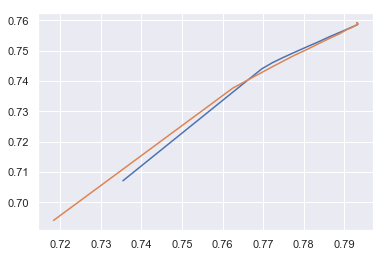

In [13]:
from scipy.stats import pearsonr

try:
    for group in [
        'all', 'non-boycott',
    ]:
        x = '{}_{}'.format(hits_metric,group)
        y = '{}_{}'.format(metric2, group)
        print(x, y)
        print(pearsonr(name2vals[x], name2vals[y]))
        plt.plot(name2vals[x], name2vals[y])
    plt.show()
except Exception as err:
    print(err)
    pass

In [14]:
# bonus
if False:
    metric = 'ndcgfull_non-boycott'
    print('1...')
    name = '1 user sample'
    print(samples_df_1m[(samples_df_1m.indices == '1-to-250') & (samples_df_1m.name == name)][metric].mean())
    print(samples_df_1m[(samples_df_1m.indices == '251-to-500') & (samples_df_1m.name == name)][metric].mean())
    print(samples_df_1m[(samples_df_1m.name == name)][metric].mean())
    print(samples_df_1m[(samples_df_1m.name == name)]['ndcg10_frac_non-boycott'].mean())

    print('3...')
    name = '3 user sample'
    print(samples_df_1m[(samples_df_1m.indices == '1-to-250') & (samples_df_1m.name == name)][metric].mean())
    print(samples_df_1m[(samples_df_1m.indices == '251-to-500') & (samples_df_1m.name == name)][metric].mean())
    print(samples_df_1m[(samples_df_1m.name == name)][metric].mean())
    print(samples_df_1m[(samples_df_1m.name == name)]['ndcg10_frac_non-boycott'].mean())

    print('6')
    name = '6 user sample'
    print(samples_df_1m[(samples_df_1m.indices == '1-to-250') & (samples_df_1m.name == name)][metric].mean())
    print(samples_df_1m[(samples_df_1m.indices == '251-to-500') & (samples_df_1m.name == name)][metric].mean())
    print(samples_df_1m[(samples_df_1m.name == name)][metric].mean())
    print(samples_df_1m[(samples_df_1m.name == name)]['ndcg10_frac_non-boycott'].mean())

    print('30')
    name = '30 user sample'
    print(samples_df_1m[(samples_df_1m.indices == '1-to-250') & (samples_df_1m.name == name)][metric].mean())
    print(samples_df_1m[(samples_df_1m.indices == '251-to-500') & (samples_df_1m.name == name)][metric].mean())
    print(samples_df_1m[(samples_df_1m.name == name)][metric].mean())
    print(samples_df_1m[(samples_df_1m.name == name)]['ndcg10_frac_non-boycott'].mean())

## Clean up the homogenous boycott "name" columns
This is helpful because our homogenous boycott plots are going to very cluttered. We want to remove as much text as possible without making the plots too confusing.

In [15]:
org_df.name = [
    x.replace('excluded', '')
    .replace('users from', '')
    .replace('using threshold 4', '')
    .replace('Top 10% contributors', 'power users')
    .strip()
    .lower()
    for x in list(org_df.name)
]
# can ignore the below warning, the code in this cell works

C:\Users\Nick\Anaconda3\lib\site-packages\pandas\core\generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [16]:
import p_b_curve
import importlib
importlib.reload(p_b_curve)
plot = p_b_curve.p_b_curve

template = 'Effect on {}, {}'

C:\Users\Nick\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Algo:SVD  |  Metric:surfaced-hits  |  #users:0.3
NB Val:0.7517548897628394  |  ALL val:0.7517548897628394
ratio_nb: -0.41413304387444655  |  ratio_all:-0.41413304387444655
=====
Size to Mean Decrease
defaultdict(<class 'dict'>, {'SVD': {0.3: 0.7517548897628394}})


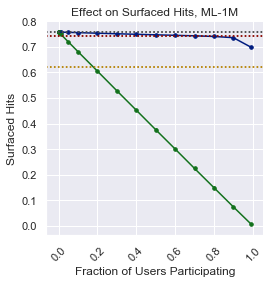

In [59]:
# Fig. 1, Upper Left
df, ds = samples_df_1m, 'ml-1m'

_ = plot(
    df[df.algo_name == 'SVD'], ds,
    show_interp=False,
    increase=False, percents=False, normalize=False,
    metrics=[
        'surfaced-hits',
        #'normhits',
    ],
    groups=[
        'all', 'non-boycott', 
        #'standards_non-boycott'
    ],
    legend=False, 
    ylabel='Surfaced Hits',
    title_template=template,
    height=4, aspect=1,
    line_names = ['SVD', 'MovieMean', 'GlobalMean'],
    print_vals=[0.3],
    algo2metric2altalgo=dataset_to_algo_to_metric_to_altalgo[ds],
    id_vars=id_vars,
    ds2standards=ds2standards
)

plt.savefig(ds + '_surfacedhits.png', bbox_inches='tight', dpi=300)
plt.show()

C:\Users\Nick\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


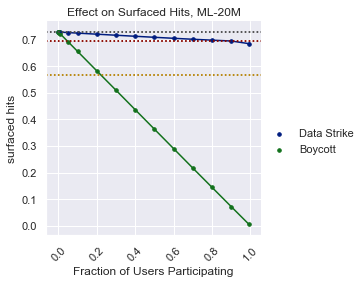

In [60]:
# Fig. 1, Upper Right

df, ds = samples_df_20m, 'ml-20m'

_ = plot(
    df[df.algo_name == 'SVD'], ds,
    show_interp=False,
    increase=False, percents=False, normalize=False,
    metrics=[
        'surfaced-hits',
        #'normhits',
    ],
    groups=[
        'all', 'non-boycott', 
        #'standards_non-boycott'
    ],
    legend=True, 
    ylabel='surfaced hits',
    title_template=template,
    height=4, aspect=1,
    line_names = ['SVD', 'MovieMean', 'GlobalMean'], #line_names=['SVD', 'MovieMean', 'GlobalMean'],
    print_vals=False,
    #ylim=(0.6, 0.8)
    algo2metric2altalgo=dataset_to_algo_to_metric_to_altalgo[ds],
    id_vars=id_vars,
    ds2standards=ds2standards
)
plt.savefig(ds + '_surfacedhits.png', bbox_inches='tight', dpi=300)
plt.show()

C:\Users\Nick\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Algo:SVD  |  Metric:surfaced-hits  |  #users:0.3
NB Val:0.7517548897628394  |  ALL val:0.7517548897628394
ratio_nb: -0.41413304387444655  |  ratio_all:-0.41413304387444655
=====
Size to Mean Decrease
defaultdict(<class 'dict'>, {'SVD': {0.3: 0.7517548897628394}})


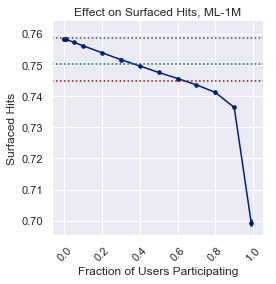

In [19]:
# Show Frac Ideal Hits from the Perspective of Remaining Users
df, ds = samples_df_1m, 'ml-1m'

_ = plot(
    df[df.algo_name == 'SVD'], ds,
    show_interp=False,
    increase=False, percents=False, normalize=False,
    metrics=[
        'surfaced-hits',
    ],
    groups=[
        'all', 
    ],
    legend=False, 
    ylabel="Surfaced Hits",
    title_template=template,
    height=4, aspect=1,
    line_names=[
        'SVD', 'KNNBasic_item_msd', 
        #'KNNBaseline_item_msd', 
        #'KNNBasic_user_msd', 
        'MovieMean'
    ],
    print_vals=[0.3],
    #ylim=(0.74, 0.761),
    algo2metric2altalgo=dataset_to_algo_to_metric_to_altalgo[ds],
    id_vars=id_vars,
    ds2standards=ds2standards
)

plt.savefig(ds + '_surfacedhits_zoomed.png', bbox_inches='tight', dpi=300)
plt.show()

C:\Users\Nick\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Algo:SVD  |  Metric:surfaced-hits  |  #users:0.3
NB Val:-0.5024132640435549  |  ALL val:-0.5024132640435549
=====
Size to Mean Decrease
defaultdict(<class 'dict'>, {'SVD': {0.3: -0.5024132640435549}})


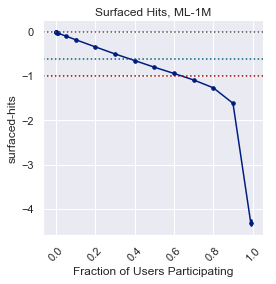

In [20]:
# ML-1M surfaced hits, normalized
df, ds = samples_df_1m, 'ml-1m'

_ = plot(
    df[df.algo_name == 'SVD'], ds,
    show_interp=False,
    increase=True, percents=True, normalize=True,
    metrics=[
        'surfaced-hits',
    ],
    groups=[
        'all', 
    ],
    legend=False, 
    ylabel="surfaced-hits",
    title_template='{}, {}',
    height=4, aspect=1,
    line_names=[
        'SVD', 'KNNBasic_item_msd', 
        #'KNNBaseline_item_msd', 
        #'KNNBasic_user_msd', 
        'MovieMean'
    ],
    print_vals=[0.3],
    #ylim=(0.74, 0.761),
    algo2metric2altalgo=dataset_to_algo_to_metric_to_altalgo[ds],
    id_vars=id_vars,
    ds2standards=ds2standards
)

#plt.savefig(ds + '_surfacedhits_zoomed.png', bbox_inches='tight', dpi=300)
plt.show()

C:\Users\Nick\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Algo:SVD  |  Metric:surfaced-hits  |  #users:0.3
NB Val:0.7171056558707138  |  ALL val:nan
ratio_nb: -0.16174058412037473  |  ratio_all:nan
=====
Size to Mean Decrease
defaultdict(<class 'dict'>, {'SVD': {0.3: 0.7171056558707138}})


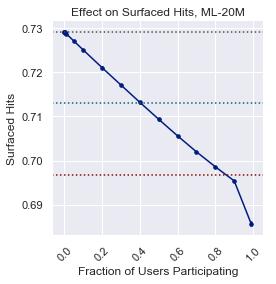

In [21]:
# Show Frac Ideal Hits from the Perspective of Remaining Users
df, ds = samples_df_20m, 'ml-20m'

twenty_algo_to_metric_to_group_to = plot(
    df[df.algo_name == 'SVD'], ds,
    show_interp=False,
    increase=False, percents=False, normalize=False,
    metrics=[
        'surfaced-hits',
    ],
    groups=[
        'all', 
    ],
    legend=False, 
    ylabel="Surfaced Hits",
    title_template=template,
    height=4, aspect=1,
    line_names=[
        'SVD', 'KNNBasic_item_msd', 
        #'KNNBaseline_item_msd', 
        #'KNNBasic_user_msd', 
        'MovieMean'
    ],
    print_vals=[0.3],
    #ylim=(0.695, 0.731),
    algo2metric2altalgo=dataset_to_algo_to_metric_to_altalgo[ds],
    id_vars=id_vars,
    ds2standards=ds2standards
)

plt.savefig(ds + '_surfacedhits_zoomed.png', bbox_inches='tight', dpi=300)
plt.show()

C:\Users\Nick\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


=====
Size to Mean Decrease
defaultdict(<class 'dict'>, {})


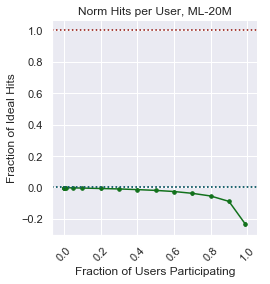

In [22]:
# Show Frac Ideal Hits from the Perspective of Remaining Users
df, ds = samples_df_20m, 'ml-20m'

twenty_algo_to_metric_to_group_to = plot(
    df[df.algo_name == 'SVD'], ds,
    show_interp=False,
    increase=True, percents=True, normalize=True,
    metrics=[
        'normhits',
    ],
    groups=[
        'non-boycott', 
    ],
    legend=False, 
    ylabel="Fraction of Ideal Hits",
    title_template='{}, {}',
    height=4, aspect=1,
    line_names=[
        'SVD', 'KNNBasic_item_msd', 
        #'KNNBaseline_item_msd', 
        #'KNNBasic_user_msd', 
        'MovieMean'
    ],
    print_vals=[0.3],
    #ylim=(0.695, 0.731),
    algo2metric2altalgo=dataset_to_algo_to_metric_to_altalgo[ds],
    id_vars=id_vars,
    ds2standards=ds2standards
)

#plt.savefig(ds + '_usernormhits.png', bbox_inches='tight', dpi=300)
plt.show()

In [23]:
pinks = {}
pinks[2] = '#f8bbd0'
pinks[3] = '#f48fb1'
pinks[4] = '#f06292'
pinks[5] = '#ec407a'
pinks[6] = '#e91e63'
pinks[7] = '#d81b60'

purples = {}
purples[2] = '#e1bee7'
purples[3] = '#ce93d8'
purples[4] = '#ba68c8'
purples[5] = '#ab47bc'
purples[6] = '#9c27b0'
purples[7] = '#8e24aa'
#https://material.io/tools/color/#!/?view.left=0&view.right=0&primary.color=E1BEE7

### Look at totalhits

C:\Users\Nick\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


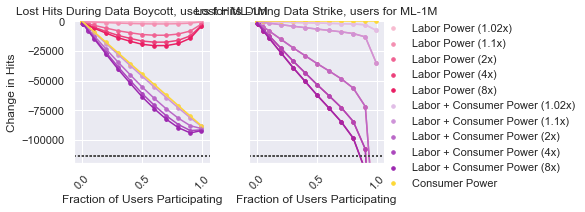

In [24]:
metric = 'totalhits'
_ = plot(
    samples_df_1m[samples_df_1m.algo_name == 'SVD'], 'ml-1m',
    show_interp=False,
    increase=True, percents=True, normalize=False,
    metrics=[
        '1.02boosthits-{}'.format(metric),
        '1.1boosthits-{}'.format(metric),
        '2boosthits-{}'.format(metric),
        '4boosthits-{}'.format(metric),
        '8boosthits-{}'.format(metric),
        
        'labor-1.02boosthits-{}'.format(metric),
        'labor-1.1boosthits-{}'.format(metric),
        'labor-2boosthits-{}'.format(metric),
        'labor-4boosthits-{}'.format(metric),
        'labor-8boosthits-{}'.format(metric),
        'consumer-1.1boosthits-{}'.format(metric),  
    ],
    groups=['all', 'non-boycott'],
    #hue='metric', col='group', row='algo_name',
    hue='metric', col='group', row='algo_name',
    
    legend=True, 
    ylabel='Change in Hits',
    title_template='Lost Hits During {} for {}',
    height=3, aspect=1,
    label_map={
        'labor-1.02boosthits-{}'.format(metric): 'Labor Power (1.02x)', 
        'labor-1.1boosthits-{}'.format(metric): 'Labor Power (1.1x)', 
        'labor-2boosthits-{}'.format(metric):  'Labor Power (2x)', 
        'labor-4boosthits-{}'.format(metric): 'Labor Power (4x)',
        'labor-8boosthits-{}'.format(metric): 'Labor Power (8x)',

        '1.02boosthits-{}'.format(metric): 'Labor + Consumer Power (1.02x)', 
        '1.1boosthits-{}'.format(metric): 'Labor + Consumer Power (1.1x)', 
        '2boosthits-{}'.format(metric): 'Labor + Consumer Power (2x)', 
        '4boosthits-{}'.format(metric): 'Labor + Consumer Power (4x)',
        '8boosthits-{}'.format(metric): 'Labor + Consumer Power (8x)',

        'consumer-1.1boosthits-{}'.format(metric): 'Consumer Power',
    },
    hue_order = [
        'labor-1.02boosthits-{}'.format(metric), 
        'labor-1.1boosthits-{}'.format(metric) ,
        'labor-2boosthits-{}'.format(metric), 
        'labor-4boosthits-{}'.format(metric),
        'labor-8boosthits-{}'.format(metric),

        '1.02boosthits-{}'.format(metric), 
        '1.1boosthits-{}'.format(metric), 
        '2boosthits-{}'.format(metric), 
        '4boosthits-{}'.format(metric),
        '8boosthits-{}'.format(metric),
        'consumer-1.1boosthits-{}'.format(metric),
    ],
    palette={
        'labor-1.02boosthits-{}'.format(metric): pinks[2], 
        'labor-1.1boosthits-{}'.format(metric): pinks[3], 
        'labor-2boosthits-{}'.format(metric):  pinks[4], 
        'labor-4boosthits-{}'.format(metric): pinks[5],
        'labor-8boosthits-{}'.format(metric): pinks[6],
        
        '1.02boosthits-{}'.format(metric): purples[2], 
        '1.1boosthits-{}'.format(metric): purples[3], 
        '2boosthits-{}'.format(metric):  purples[4], 
        '4boosthits-{}'.format(metric): purples[5],
        '8boosthits-{}'.format(metric): purples[6],
        
        'consumer-1.1boosthits-{}'.format(metric): '#fdd835',
    },
    plot_horiz_lines=True,
    line_names=['MaxDamage',], ylim=(-120000, 500),
    print_vals=None,
    algo2metric2altalgo=dataset_to_algo_to_metric_to_altalgo['ml-1m'],
    id_vars=id_vars,
    ds2standards=ds2standards
)
#plt.ylim(-114000, 200)
plt.savefig('ml-1m_totalhits.png', bbox_inches='tight', dpi=300)
plt.show()

C:\Users\Nick\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


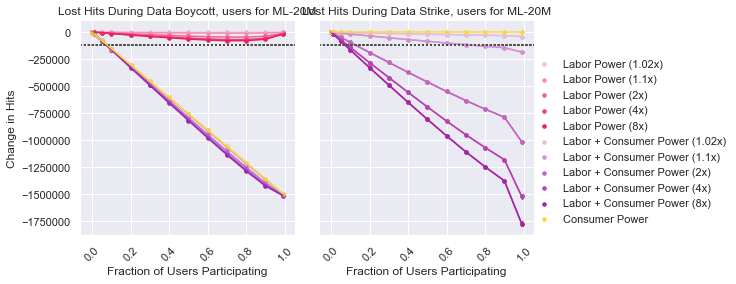

In [25]:
metric = 'totalhits'
df = samples_df_20m
ds = 'ml-20m'
_ = plot(
    df[df.algo_name == 'SVD'], ds,
    show_interp=False,
    increase=True, percents=True, normalize=False,
    metrics=[
        '1.02boosthits-{}'.format(metric),
        '1.1boosthits-{}'.format(metric),
        '2boosthits-{}'.format(metric),
        '4boosthits-{}'.format(metric),
        '8boosthits-{}'.format(metric),
        
        'labor-1.02boosthits-{}'.format(metric),
        'labor-1.1boosthits-{}'.format(metric),
        'labor-2boosthits-{}'.format(metric),
        'labor-4boosthits-{}'.format(metric),
        'labor-8boosthits-{}'.format(metric),
        'consumer-1.1boosthits-{}'.format(metric),  
    ],
    groups=['all', 'non-boycott'],
    #hue='metric', col='group', row='algo_name',
    hue='metric', col='group', row='algo_name',
    
    legend=True, 
    ylabel='Change in Hits',
    title_template='Lost Hits During {} for {}',
    height=4, aspect=1,
    label_map={
        'labor-1.02boosthits-{}'.format(metric): 'Labor Power (1.02x)', 
        'labor-1.1boosthits-{}'.format(metric): 'Labor Power (1.1x)', 
        'labor-2boosthits-{}'.format(metric):  'Labor Power (2x)', 
        'labor-4boosthits-{}'.format(metric): 'Labor Power (4x)',
        'labor-8boosthits-{}'.format(metric): 'Labor Power (8x)',

        '1.02boosthits-{}'.format(metric): 'Labor + Consumer Power (1.02x)', 
        '1.1boosthits-{}'.format(metric): 'Labor + Consumer Power (1.1x)', 
        '2boosthits-{}'.format(metric): 'Labor + Consumer Power (2x)', 
        '4boosthits-{}'.format(metric): 'Labor + Consumer Power (4x)',
        '8boosthits-{}'.format(metric): 'Labor + Consumer Power (8x)',

        'consumer-1.1boosthits-{}'.format(metric): 'Consumer Power',
    },
    hue_order = [
        'labor-1.02boosthits-{}'.format(metric), 
        'labor-1.1boosthits-{}'.format(metric) ,
        'labor-2boosthits-{}'.format(metric), 
        'labor-4boosthits-{}'.format(metric),
        'labor-8boosthits-{}'.format(metric),

        '1.02boosthits-{}'.format(metric), 
        '1.1boosthits-{}'.format(metric), 
        '2boosthits-{}'.format(metric), 
        '4boosthits-{}'.format(metric),
        '8boosthits-{}'.format(metric),
        'consumer-1.1boosthits-{}'.format(metric),
    ],
    palette={
        'labor-1.02boosthits-{}'.format(metric): pinks[2], 
        'labor-1.1boosthits-{}'.format(metric): pinks[3], 
        'labor-2boosthits-{}'.format(metric):  pinks[4], 
        'labor-4boosthits-{}'.format(metric): pinks[5],
        'labor-8boosthits-{}'.format(metric): pinks[6],
        
        '1.02boosthits-{}'.format(metric): purples[2], 
        '1.1boosthits-{}'.format(metric): purples[3], 
        '2boosthits-{}'.format(metric):  purples[4], 
        '4boosthits-{}'.format(metric): purples[5],
        '8boosthits-{}'.format(metric): purples[6],
        
        'consumer-1.1boosthits-{}'.format(metric): '#fdd835',
    },
    plot_horiz_lines=True,
    line_names=['MaxDamage',], 
    #ylim=(-120000, 500),
    print_vals=None,
    algo2metric2altalgo=dataset_to_algo_to_metric_to_altalgo[ds],
    id_vars=id_vars,
    ds2standards=ds2standards
)
#plt.ylim(-114000, 200)
plt.savefig('ml-1m_complicatedhits.svg', bbox_inches='tight', dpi=300)
plt.show()

In [26]:

# _ = p_b_curve(
#     samples_df_1m[samples_df_1m.algo_name == 'SVD'], 'ml-1m',
#     show_interp=False,
#     increase=True,percents=True, normalize=True,
#     metrics=['ndcg10',],
#     groups=['non-boycott', 'all', ],
#     legend=False,
#     ylabel='nDCG@10 personalization factor',
#     height=4,
#     line_names=[
#         'Zero', 'KNNBasic_item_msd', 
#         #'KNNBaseline_item_msd', 'KNNBasic_user_msd', 
#         'MovieMean']
# )
# plt.ylim(-1.2, 0.05)
# plt.savefig('ml-1m_ndcg_curve.png', bbox_inches='tight', dpi=300)
# plt.show()

### Find intersection of the non-boycott curve with horizontal lines

In [27]:
import p_b_curve
import importlib
importlib.reload(p_b_curve)
plot = p_b_curve.p_b_curve

C:\Users\Nick\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Algo:SVD  |  Metric:ndcg10  |  #users:0.3
NB Val:-1.259723247573784  |  ALL val:-1.259723247573784
Algo:SVD  |  Metric:normhits  |  #users:0.3
NB Val:-0.8686979290773396  |  ALL val:-0.8686979290773396
Algo:SVD  |  Metric:surfaced-hits  |  #users:0.3
NB Val:-0.9120055342431352  |  ALL val:-0.9120055342431352
Algo:SVD  |  Metric:totalhits  |  #users:0.3
NB Val:-0.9120055342431352  |  ALL val:-0.9120055342431352
=====
Size to Mean Decrease
defaultdict(<class 'dict'>, {'SVD': {0.3: -0.9881080612843485}})


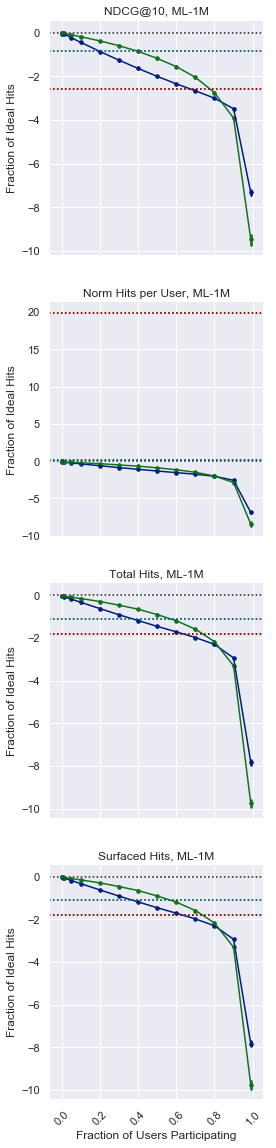

In [28]:
# Show Frac Ideal Hits from the Perspective of Remaining Users
USE_PERCENTS = 1
USE_INCREASE = 1
NORMALIZE = 0


df, ds = samples_df_1m, 'ml-1m'

algo_to_metric_to_group_to = plot(
    df[df.algo_name == 'SVD'], ds,
    show_interp=False,
    increase=USE_INCREASE, percents=USE_PERCENTS, normalize=NORMALIZE,
    metrics=[
        'ndcg10', 
        'normhits',
        'surfaced-hits',
        #'ndcgfull',
        'totalhits'
    ],
    groups=[
        'non-boycott', 'all',
    ],
    legend=False, 
    ylabel="Fraction of Ideal Hits",
    title_template='{}, {}',
    height=4, aspect=1,
    line_names=[
        'SVD', 'KNNBasic_item_msd', 
        #'KNNBaseline_item_msd', 
        #'KNNBasic_user_msd', 
        'MovieMean'
    ],
    print_vals=[0.3],
    algo2metric2altalgo=dataset_to_algo_to_metric_to_altalgo[ds],
    id_vars=id_vars,
    ds2standards=ds2standards
)

#plt.savefig(ds + '_usernormhits.png', bbox_inches='tight', dpi=300)
plt.show()

In [29]:
metric = 'totalhits'
# comparisons = ds2standards['ml-1m']
# comparisons = {
#     key: comparisons[key].get(metric, 0) for key in comparisons.keys()
# }
comparisons = dataset_to_algo_to_metric_to_altalgo['ml-1m']['SVD'][metric]
#movie_val = -1 * dataset_to_algo_to_metric_to_altalgo['ml-1m']['SVD'][metric]['MovieMean']
for group in [
    'all', 
    #'non-boycott'
]:
    found_item, found_user = False, False
    found_itembasic = False
    for x in range(0, num_ratings['ml-1m'], int(num_ratings['ml-1m'] / 10000)):
        y = algo_to_metric_to_group_to['SVD'][metric][group]['interp_ratings'](x)
        #print(x,y)
        #print(comparisons['KNNBasic_item_msd'])

#         if not found_item:
#             if y <= comparisons['KNNBaseline_item_msd']:
#                 print(group + ' found item:')
#                 print(x / num_ratings['ml-1m'])
#                 found_item = True
#         if not found_user:
#             if y <= comparisons['KNNBasic_user_msd']:
#                 print(group + ' found user')
#                 print(x / num_ratings['ml-1m'])
#                 found_user = True
        if not found_itembasic:
            if y <= comparisons['KNNBasic_item_msd']:
                print(group + ' found knnbasicitem')
                print(x / num_ratings['ml-1m'])
                found_itembasic = True

all found knnbasicitem
0.37532155779442095


In [30]:
# d = {}
# group = 'non-boycott'
# print(group)
# d['30_1m'] = algo_to_metric_to_group_to['SVD']['ndcg10'][group]['interp_ratings'](0.3 * num_ratings['ml-1m']) * 100
# d['30_20m'] = twenty_algo_to_metric_to_group_to['SVD']['ndcg10'][group]['interp_ratings'](0.3 * num_ratings['ml-20m']) * 100
# print(d)

# group = 'all'
# print(group)
# d['30_1m'] = algo_to_metric_to_group_to['SVD']['ndcg10'][group]['interp_ratings'](0.3 * num_ratings['ml-1m']) * 100
# d['30_20m'] = twenty_algo_to_metric_to_group_to['SVD']['ndcg10'][group]['interp_ratings'](0.3 * num_ratings['ml-20m']) * 100
# print(d)

In [31]:
# d = {}
# d[19] = twenty_algo_to_metric_to_group_to['SVD']['ndcg10'][group]['interp_ratings'](0.19 * num_ratings['ml-20m']) * 100
# d[44] = twenty_algo_to_metric_to_group_to['SVD']['ndcg10'][group]['interp_ratings'](0.44 * num_ratings['ml-20m']) * 100
# print(d)

# Targeted/Homogenous Boycotts (Results Part 2)

In [32]:
def half_users(df):
    return df[(
        (df.userfrac == 0.5) & (df.ratingfrac == 1.0) 
        #& (df.algo_name == 'SVD')
    )]

In [33]:
def half_ratings(df):
    return df[(
        (df.userfrac == 1.0) & (df.ratingfrac == 0.5)
    )]

In [34]:
def all_users_all_ratings(df):
    return df[(
        (df.userfrac == 1.0) & (df.ratingfrac == 1.0)
    )]

In [35]:

#metrics += ['hits-prec5t4', 'labor-hits-prec5t4', 'consumer-hits-prec5t4']

metrics = [
    #'surfaced-hits', 
    'totalhits'
]

normed_org_df = org_df.copy()
if NORMALIZE:
    for metric in metrics:
        for algo_name in algo_names:
            movie_val = abs(dataset_to_algo_to_metric_to_altalgo['ml-1m']['SVD'][metric]['MovieMean'])
            for group in ['non-boycott', 'like-boycott']:
                col = 'percent_increase_{}_{}'.format(metric, group)

                normed_org_df.loc[
                    normed_org_df.algo_name == algo_name, col
                ] = org_df.loc[org_df.algo_name == algo_name, col] / movie_val
                
for metric in metrics:
    expec = []
    col = '{}_expected'.format(metric)
    if USE_INCREASE:
        col = 'increase_' + col
    if USE_PERCENTS:
        col = 'percent_' + col
    for i, row in normed_org_df.iterrows():
        x = row.num_ratings_missing
        expec.append(float(algo_to_metric_to_group_to[row.algo_name][metric]['non-boycott']['interp_ratings'](x)))
    kwargs = {col: expec}
    normed_org_df = normed_org_df.assign(**kwargs)

## LB = like-boycott
### So lbless is the number cases where the like boycott performance change was less than expected

In [36]:
from p_b_curve import select_cols, fill_in_longform
ylabel = 'ylabel'

def plot2(
        df, metrics, groups,
        increase=False, percents=False, kind='bar', height=4, flip=False, filename='tmp.svg', save=False,
        palette=None, aspect=1
    ):
    """
    Plots the results of homogenous boycotts
    e.g. 50% of Comedy fans boycott together
    """
    print('len of df (number of experiments included)', len(df.index))
    for name in list(set(df.name)):
#        tmp = df[df.name == name].num_ratings_missing.mean()
        tmp = df[df.name == name].num_users_boycotting.mean()
        print('Num users boycotting: {}. As a percent: {}'.format(tmp, tmp*100))
#         print('name', name)
#         print('mean number of ratings missing', tmp)pl
#         print(algo_to_metric_to_group_to['SVD']['ndcg10']['non-boycott']['interp_ratings'](tmp))
    increase_cols = select_cols(list(df.columns.values), metrics, groups, increase=increase, percents=percents)
    increase_cols = [x for x in increase_cols if 'vanilla' not in x]
    longform = df[increase_cols + id_vars].melt(
        id_vars = id_vars,
        var_name='increase_type'
    )
    longform = fill_in_longform(longform)
    if flip:
        x = "name"
        y = "value"
    else:
        x = "value"
        y = "name"
    if '?' in filename:
        legend = False
    else:
        legend = True
    grid = sns.factorplot(
        x=x, y=y, hue="group", data=longform,
        height=height, kind=kind, col='algo_name', row='metric',
        sharex=False,
        row_order=metrics,
        legend=legend,
        legend_out=True,
        palette=palette,
        aspect=aspect
    )
    a = grid.axes
    
    name_to_ratios = defaultdict(list)
    diffs = defaultdict(dict)
    ratios = defaultdict(dict)
    vals = defaultdict(dict)
    name_to_counts = defaultdict(lambda: defaultdict(int))
    
    for x in grid.facet_data():
        i_row, i_col, i_hue = x[0]
        metric = grid.row_names[i_row]
        algo_name = grid.col_names[i_col]
        if grid.hue_names:
            group = grid.hue_names[i_hue]        
        
        if NORMALIZE:
            val = -1
        else:
            val = abs(dataset_to_algo_to_metric_to_altalgo['ml-1m']['SVD'][metric]['MovieMean'])
        
        if flip:
            grid.axes[i_row, i_col].axhline(0, color='0.7', linestyle='-')
        else:
            grid.axes[i_row, i_col].axvline(0, color='0.7', linestyle='-')
            grid.axes[i_row, i_col].axvline(val, color='0.7', linestyle='-')
        
        cols = {}
        for col in increase_cols:
            if metric == col.split('_')[-2]:
                
                if 'expected' in col:
                    cols['expec'] = col
                if 'not-like' in col:
                    cols['not-like'] = col
                elif 'non-boycott' in col:
                    cols['nb'] = col
                elif 'like-boycott' in col:
                    cols['lb'] = col
        for name in list(set(longform.name)):
            mask = (
                (longform.metric == metric) &
                (longform.algo_name == algo_name) &
                (longform.name == name)
            )
            
            masked = longform[mask]
            try:
                arrs = {}
                print(cols)
                for key in cols:
                    arrs[key] = np.array(masked[masked.increase_type == cols[key]].value)
                
                means = {key: np.mean(arrs[key]) for key in arrs}
                print(means)
                
                ratio = means['nb'] / means['expec']
                diff = means['nb'] - means['expec']
                
                lb_diff = means['lb'] / np.mean(np.array(masked.num_users_boycotting))#- means['not-like']
                lb_ratio = means['lb'] / means['not-like']

                pval = stats.ttest_ind(arrs['expec'],arrs['nb'], equal_var=False).pvalue                
                name_to_counts[name]['total'] += 1
                
                print('{} {} {}, {}, {}'.format(metric, algo_name, name, cols['expec'], cols['nb']))
                print('Ratio: {}, pval: {}'.format(ratio, pval))
                print('LB to NB ratio: {}'.format(lb_ratio))
                print('lb_diff, mean_lb - mean_nl', lb_diff)
                print('pos = lb has more hits')
                name_to_ratios[name].append(ratio)
                diffs['nb'][name] = diff
                diffs['lb'][name] = lb_diff
                
                ratios['nb'][name] = ratio
                ratios['lb'][name] = lb_ratio
                
                vals['nb'][name] = means['nb']
                vals['lb'][name] = means['lb']
                vals['not-like'][name] = means['not-like']
                
                if pval < 0.5:
                    name_to_counts[name]['total_sig'] += 1

                if diff < 0:
                    name_to_counts[name]['total_less'] += 1
                else:
                    name_to_counts[name]['total_more'] += 1
                #print('lb info', lb_diff, lb_mean, nb_mean)
                if lb_diff < 0:
                    name_to_counts[name]['total_lbless'] += 1
            except Exception as err:
                print(err)
                print(algo_name, metric)
    total = 0
    total_sig = 0
    total_less = 0
    total_more = 0
    total_lbless = 0
    
    for name, counts in name_to_counts.items():
        total += counts['total']
        total_sig += counts['total_sig']
        total_less += counts['total_less']
        total_more += counts['total_more']
        total_lbless += counts['total_lbless']

    print('Totals:')
    print('{} lbless, {} sig, {} less, and {} more out of {} total'.format(
            total_lbless, total_sig, total_less,
            total_more, total)
        )
    if save:
        new_labels = ['Similar Users', 'Not Participating\n Users', 'Expected']
        for t, l in zip(grid._legend.texts, new_labels): t.set_text(l)
        if 'h2' in filename:
            grid.set_ylabels("")
        else:
            grid.set_ylabels(ylabel)
        grid.set_xlabels("")
        grid.set_titles("")
        plt.savefig(filename, size=(3, 3), bbox_inches='tight', dpi=300)
    return grid, (total, total_sig, total_less, total_more, total_lbless), (diffs, ratios, vals)


In [37]:
palette={'all': 'b', 'non-boycott': 'g', 'expected': 'y', 'like-boycott': 'c', 'not-like-boycott': 'r'}

def plot_all_three_scenarios(df, height=6):

    total, total_sig, total_less, total_more, total_lbless = 0, 0, 0, 0, 0
    
    half_users_df = half_users(df)
    if not half_users_df.empty:
        grid, (total2, total_sig2, total_less2, total_more2, total_lbless2), (diffs, ratios, vals) = plot2(
            half_users_df,
            metrics=metrics,
            increase=USE_INCREASE, percents=USE_PERCENTS,
            flip=True,
            groups=[
                'non-boycott', 'like-boycott', 
                'expected', 
                'not-like-boycott',
            ],
            height=height,
            kind='bar',
            palette=palette
        )
        grid.fig.suptitle('Half Users')
        total += total2
        total_sig += total_sig2
        total_less += total_less2
        total_more += total_more2
        total_lbless += total_lbless2
        print('total2', total2, total)
    
    return (total, total_sig, total_less, total_more, total_lbless), (diffs, ratios, vals)

In [38]:
normed_org_df = normed_org_df[normed_org_df.algo_name == 'SVD']

In [39]:
gender_boycotts = normed_org_df[normed_org_df['type'] == 'gender']
age_boycotts = normed_org_df[normed_org_df['type'] == 'age']
occupation_boycotts = normed_org_df[normed_org_df['type'] == 'occupation']
power_boycotts = normed_org_df[normed_org_df['type'] == 'power']
genre_boycotts = normed_org_df[normed_org_df['type'] == 'genre']

In [40]:
running_totals = {
    'total': 0,
    'total_sig': 0,
    'total_less': 0,
    'total_more': 0,
    'total_lbless': 0
}
all_diffs = {
    'lb': {},
    'nb': {}
}
all_vals = {
    'lb': {},
    'nb': {},
    'not-like': {},
}
all_ratios = {
    'lb': {},
    'nb': {}
}

# Make plots for paper here.

len of df (number of experiments included) 190
Num users boycotting: 0.14139072847682124. As a percent: 14.139072847682124
Num users boycotting: 0.3586092715231786. As a percent: 35.86092715231786
Num users boycotting: 0.04999999999999998. As a percent: 4.999999999999998
Num users boycotting: 0.007284768211920532. As a percent: 0.7284768211920531


C:\Users\Nick\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\Nick\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


{'lb': 'percent_increase_totalhits_like-boycott', 'not-like': 'percent_increase_totalhits_not-like-boycott'}
{'lb': -0.3785081505990596, 'not-like': -0.08929877792835414}
'nb'
SVD totalhits
{'lb': 'percent_increase_totalhits_like-boycott', 'not-like': 'percent_increase_totalhits_not-like-boycott'}
{'lb': -0.7090938945436946, 'not-like': -0.6415628133505276}
'nb'
SVD totalhits
{'lb': 'percent_increase_totalhits_like-boycott', 'not-like': 'percent_increase_totalhits_not-like-boycott'}
{'lb': -0.7606702354077187, 'not-like': -0.4455063431857616}
'nb'
SVD totalhits
{'lb': 'percent_increase_totalhits_like-boycott', 'not-like': 'percent_increase_totalhits_not-like-boycott'}
{'lb': -0.08725856620796262, 'not-like': -0.07843803578701951}
'nb'
SVD totalhits
Totals:
0 lbless, 0 sig, 0 less, and 0 more out of 0 total


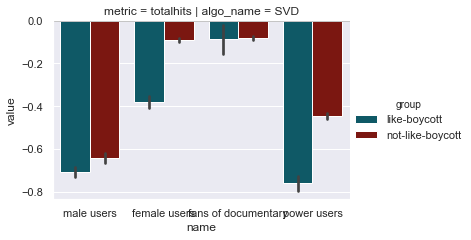

In [41]:
df1 = half_users(gender_boycotts)
df2 = half_users(genre_boycotts)
df3 = half_users(power_boycotts)

grid, (total, total_sig, total_less, total_more, total_lbless), (diffs, ratios, vals) = plot2(
    pd.concat([df1[
        #(df1.name.str.contains('female')) & 
        (df1.algo_name == 'SVD')],
        df2[(df2.name.str.contains('documentary')) & (df2.algo_name == 'SVD')],
        df3[(df3.name.str.contains('power')) & (df3.algo_name == 'SVD')]
    
    ]),
    metrics=metrics,
    increase=USE_INCREASE, percents=USE_PERCENTS,
    groups=[
        #'non-boycott', 
        'like-boycott', 
        #'expected',
        'not-like-boycott',
    ],
    height=3.5,
    kind='bar',
    flip=True,
    filename='h1.svg', save=False,
    palette=palette,
    aspect=1.5
)

plt.show()

## Male User and Female User Boycotts

len of df (number of experiments included) 100
Num users boycotting: 0.14139072847682124. As a percent: 14.139072847682124
Num users boycotting: 0.3586092715231786. As a percent: 35.86092715231786


C:\Users\Nick\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\Nick\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


{'lb': 'percent_increase_totalhits_like-boycott', 'nb': 'percent_increase_totalhits_non-boycott', 'not-like': 'percent_increase_totalhits_not-like-boycott', 'expec': 'percent_increase_totalhits_expected'}
{'lb': -0.3785081505990596, 'nb': -0.13069019056499814, 'not-like': -0.08929877792835414, 'expec': -0.16268376048994793}
totalhits SVD female users, percent_increase_totalhits_expected, percent_increase_totalhits_non-boycott
Ratio: 0.8033388838037916, pval: 2.1249218834385704e-06
LB to NB ratio: 4.2386711148806855
lb_diff, mean_lb - mean_nl -2.677036568639719
pos = lb has more hits
{'lb': 'percent_increase_totalhits_like-boycott', 'nb': 'percent_increase_totalhits_non-boycott', 'not-like': 'percent_increase_totalhits_not-like-boycott', 'expec': 'percent_increase_totalhits_expected'}
{'lb': -0.7090938945436946, 'nb': -0.6819315076093885, 'not-like': -0.6415628133505276, 'expec': -0.6028904913540893}
totalhits SVD male users, percent_increase_totalhits_expected, percent_increase_totalhi

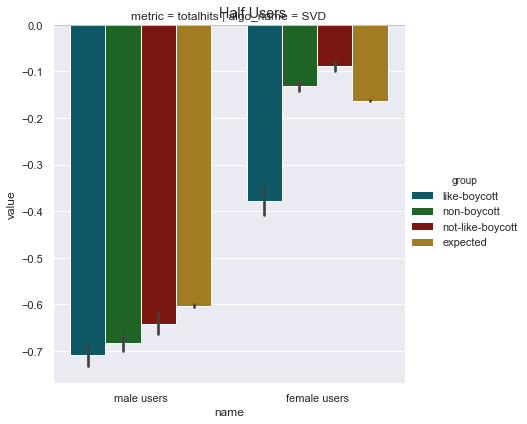

In [42]:
(total, total_sig, total_less, total_more, total_lbless), (diffs, ratios, vals) = plot_all_three_scenarios(gender_boycotts)
running_totals['total'] += total
running_totals['total_sig'] += total_sig
running_totals['total_less'] += total_less
running_totals['total_more'] += total_more
running_totals['total_lbless'] += total_lbless
for key in all_diffs.keys():
    all_diffs[key].update(diffs[key])
    all_ratios[key].update(ratios[key])
for key in all_vals.keys():
    all_vals[key].update(vals[key])
    
print(all_vals)

plt.show()

# Power Boycotts

Below, the power boycotts show a very weird results. Warrants double checks.

len of df (number of experiments included) 100
Num users boycotting: 0.051324503311258284. As a percent: 5.1324503311258285
Num users boycotting: 0.04999999999999998. As a percent: 4.999999999999998


C:\Users\Nick\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\Nick\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


{'lb': 'percent_increase_totalhits_like-boycott', 'nb': 'percent_increase_totalhits_non-boycott', 'not-like': 'percent_increase_totalhits_not-like-boycott', 'expec': 'percent_increase_totalhits_expected'}
{'lb': 0.07723871739637103, 'nb': -0.031542287284574776, 'not-like': -0.032478737969039516, 'expec': -0.034525881839211195}
totalhits SVD bottom 10% contributors, percent_increase_totalhits_expected, percent_increase_totalhits_non-boycott
Ratio: 0.9135838276765479, pval: 0.619001757602705
LB to NB ratio: -2.378131732519876
lb_diff, mean_lb - mean_nl 1.5049092034647775
pos = lb has more hits
{'lb': 'percent_increase_totalhits_like-boycott', 'nb': 'percent_increase_totalhits_non-boycott', 'not-like': 'percent_increase_totalhits_not-like-boycott', 'expec': 'percent_increase_totalhits_expected'}
{'lb': -0.7606702354077187, 'nb': -0.5064645666991994, 'not-like': -0.4455063431857616, 'expec': -0.27480547549140616}
totalhits SVD power users, percent_increase_totalhits_expected, percent_incre

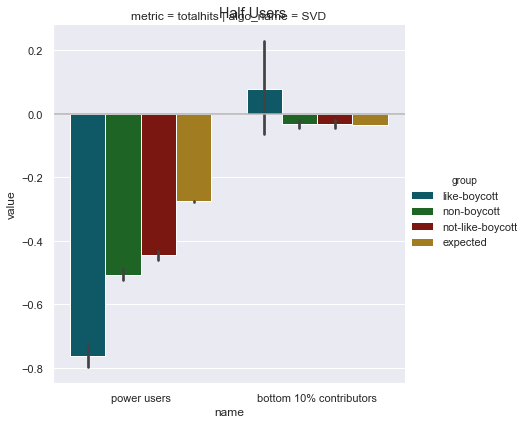

In [43]:
(total, total_sig, total_less, total_more, total_lbless), (diffs, ratios, vals) = plot_all_three_scenarios(power_boycotts)
running_totals['total'] += total
running_totals['total_sig'] += total_sig
running_totals['total_less'] += total_less
running_totals['total_more'] += total_more
running_totals['total_lbless'] += total_lbless

for key in all_diffs.keys():
    all_diffs[key].update(diffs[key])
    all_ratios[key].update(ratios[key])
for key in all_vals.keys():
    all_vals[key].update(vals[key])


plt.show()

# Age Boycotts

len of df (number of experiments included) 350
Num users boycotting: 0.17350993377483445. As a percent: 17.350993377483444
Num users boycotting: 0.09139072847682124. As a percent: 9.139072847682124
Num users boycotting: 0.041059602649006634. As a percent: 4.105960264900664
Num users boycotting: 0.0183774834437086. As a percent: 1.8377483443708602
Num users boycotting: 0.09867549668874175. As a percent: 9.867549668874174
Num users boycotting: 0.04552980132450333. As a percent: 4.552980132450333
Num users boycotting: 0.03145695364238411. As a percent: 3.145695364238411


C:\Users\Nick\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\Nick\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


{'lb': 'percent_increase_totalhits_like-boycott', 'nb': 'percent_increase_totalhits_non-boycott', 'not-like': 'percent_increase_totalhits_not-like-boycott', 'expec': 'percent_increase_totalhits_expected'}
{'lb': -0.38471230191180583, 'nb': -0.3196678741358701, 'not-like': -0.29940680041373996, 'expec': -0.28769809177578054}
totalhits SVD 25-34, percent_increase_totalhits_expected, percent_increase_totalhits_non-boycott
Ratio: 1.1111226778139545, pval: 3.736376001722068e-05
LB to NB ratio: 1.2849150432795284
lb_diff, mean_lb - mean_nl -2.217235022468804
pos = lb has more hits
{'lb': 'percent_increase_totalhits_like-boycott', 'nb': 'percent_increase_totalhits_non-boycott', 'not-like': 'percent_increase_totalhits_not-like-boycott', 'expec': 'percent_increase_totalhits_expected'}
{'lb': -0.37875222766380806, 'nb': -0.14981290493905985, 'not-like': -0.12605829483136577, 'expec': -0.11773929763742316}
totalhits SVD 18-24, percent_increase_totalhits_expected, percent_increase_totalhits_non-bo

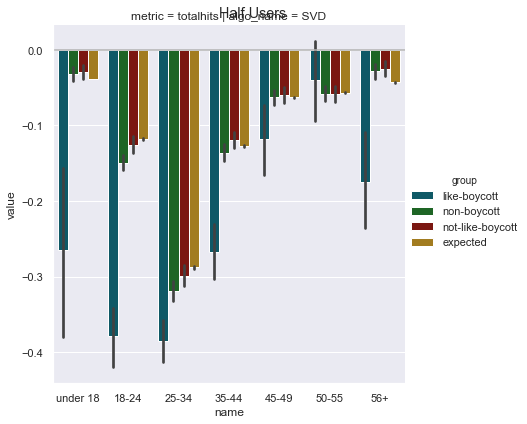

In [44]:
(total, total_sig, total_less, total_more, total_lbless), (diffs, ratios, vals) = plot_all_three_scenarios(age_boycotts)
running_totals['total'] += total
running_totals['total_sig'] += total_sig
running_totals['total_less'] += total_less
running_totals['total_more'] += total_more
running_totals['total_lbless'] += total_lbless

for key in all_diffs.keys():
    all_diffs[key].update(diffs[key])
    all_ratios[key].update(ratios[key])
for key in all_vals.keys():
    all_vals[key].update(vals[key])

plt.show()


# Occupation Boycotts

len of df (number of experiments included) 840
Num users boycotting: 0.0013245033112582788. As a percent: 0.13245033112582788
Num users boycotting: 0.05629139072847681. As a percent: 5.629139072847681
Num users boycotting: 0.043708609271523154. As a percent: 4.370860927152315
Num users boycotting: 0.02317880794701987. As a percent: 2.317880794701987
Num users boycotting: 0.025000000000000012. As a percent: 2.5000000000000013
Num users boycotting: 0.03211920529801326. As a percent: 3.2119205298013256
Num users boycotting: 0.019867549668874166. As a percent: 1.9867549668874167
Num users boycotting: 0.06291390728476821. As a percent: 6.291390728476822
Num users boycotting: 0.01059602649006623. As a percent: 1.059602649006623
Num users boycotting: 0.005960264900662255. As a percent: 0.5960264900662254
Num users boycotting: 0.011754966887417225. As a percent: 1.1754966887417224
Num users boycotting: 0.014238410596026489. As a percent: 1.423841059602649
Num users boycotting: 0.00927152317880

C:\Users\Nick\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\Nick\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


{'lb': 'percent_increase_totalhits_like-boycott', 'nb': 'percent_increase_totalhits_non-boycott', 'not-like': 'percent_increase_totalhits_not-like-boycott', 'expec': 'percent_increase_totalhits_expected'}
{'lb': 0.9221771392966401, 'nb': -0.03452718927364071, 'not-like': -0.03584283852320052, 'expec': -0.030596484907664402}
totalhits SVD farmer, percent_increase_totalhits_expected, percent_increase_totalhits_non-boycott
Ratio: 1.1284691485913687, pval: 0.3799928797952127
LB to NB ratio: -25.728351249294306
lb_diff, mean_lb - mean_nl 696.2437401689634
pos = lb has more hits
{'lb': 'percent_increase_totalhits_like-boycott', 'nb': 'percent_increase_totalhits_non-boycott', 'not-like': 'percent_increase_totalhits_not-like-boycott', 'expec': 'percent_increase_totalhits_expected'}
{'lb': -0.0532046119603105, 'nb': -0.0894374356658835, 'not-like': -0.09159054555697616, 'expec': -0.07288525812811739}
totalhits SVD executive/managerial, percent_increase_totalhits_expected, percent_increase_total

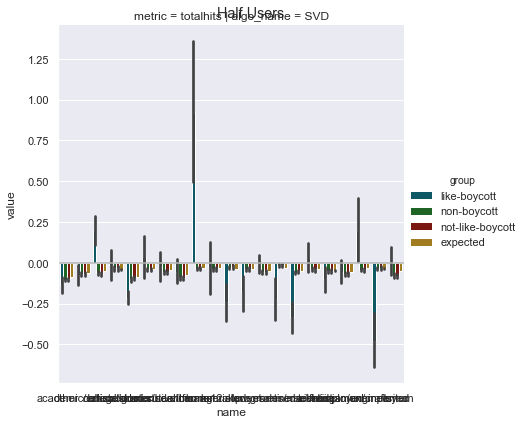

In [45]:
(total, total_sig, total_less, total_more, total_lbless), (diffs, ratios, vals) = plot_all_three_scenarios(occupation_boycotts)
running_totals['total'] += total
running_totals['total_sig'] += total_sig
running_totals['total_less'] += total_less
running_totals['total_more'] += total_more
running_totals['total_lbless'] += total_lbless

for key in all_diffs.keys():
    all_diffs[key].update(diffs[key])
    all_ratios[key].update(ratios[key])
for key in all_vals.keys():
    all_vals[key].update(vals[key])
plt.show()

# Genre Boycotts

len of df (number of experiments included) 720
Num users boycotting: 0.007284768211920532. As a percent: 0.7284768211920531
Num users boycotting: 0.08311258278145703. As a percent: 8.311258278145703
Num users boycotting: 0.011589403973509936. As a percent: 1.1589403973509935
Num users boycotting: 0.026986754966887412. As a percent: 2.6986754966887414
Num users boycotting: 0.09602649006622513. As a percent: 9.602649006622514
Num users boycotting: 0.06821192052980136. As a percent: 6.821192052980137
Num users boycotting: 0.030960264900662244. As a percent: 3.096026490066224
Num users boycotting: 0.08642384105960267. As a percent: 8.642384105960268
Num users boycotting: 0.07847682119205293. As a percent: 7.8476821192052935
Num users boycotting: 0.011589403973509936. As a percent: 1.1589403973509935
Num users boycotting: 0.02384105960264902. As a percent: 2.3841059602649017
Num users boycotting: 0.16953642384105969. As a percent: 16.95364238410597
Num users boycotting: 0.031125827814569546

C:\Users\Nick\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\Nick\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


{'lb': 'percent_increase_totalhits_like-boycott', 'nb': 'percent_increase_totalhits_non-boycott', 'not-like': 'percent_increase_totalhits_not-like-boycott', 'expec': 'percent_increase_totalhits_expected'}
{'lb': -0.08725856620796262, 'nb': -0.07859324609453548, 'not-like': -0.07843803578701951, 'expec': -0.04539213125804929}
totalhits SVD fans of documentary, percent_increase_totalhits_expected, percent_increase_totalhits_non-boycott
Ratio: 1.7314288603842258, pval: 9.045182158775765e-09
LB to NB ratio: 1.112452209345135
lb_diff, mean_lb - mean_nl -11.978221361274864
pos = lb has more hits
{'lb': 'percent_increase_totalhits_like-boycott', 'nb': 'percent_increase_totalhits_non-boycott', 'not-like': 'percent_increase_totalhits_not-like-boycott', 'expec': 'percent_increase_totalhits_expected'}
{'lb': -0.124323744564018, 'nb': -0.21368229473160394, 'not-like': -0.23796486582961052, 'expec': -0.17881304802659628}
totalhits SVD fans of war, percent_increase_totalhits_expected, percent_increa

{'lb': 'percent_increase_totalhits_like-boycott', 'nb': 'percent_increase_totalhits_non-boycott', 'not-like': 'percent_increase_totalhits_not-like-boycott', 'expec': 'percent_increase_totalhits_expected'}
{'lb': -0.2369806881583906, 'nb': -0.045493982974774826, 'not-like': -0.03781486115556747, 'expec': -0.047135440098848236}
totalhits SVD fans of horror, percent_increase_totalhits_expected, percent_increase_totalhits_non-boycott
Ratio: 0.9651757335747562, pval: 0.762394620550548
LB to NB ratio: 6.266866541793451
lb_diff, mean_lb - mean_nl -14.910034963298742
pos = lb has more hits
{'lb': 'percent_increase_totalhits_like-boycott', 'nb': 'percent_increase_totalhits_non-boycott', 'not-like': 'percent_increase_totalhits_not-like-boycott', 'expec': 'percent_increase_totalhits_expected'}
{'lb': 0.0033253749708802268, 'nb': -0.06786575440900706, 'not-like': -0.07442833299669374, 'expec': -0.07110374307334652}
totalhits SVD fans of adventure, percent_increase_totalhits_expected, percent_incre

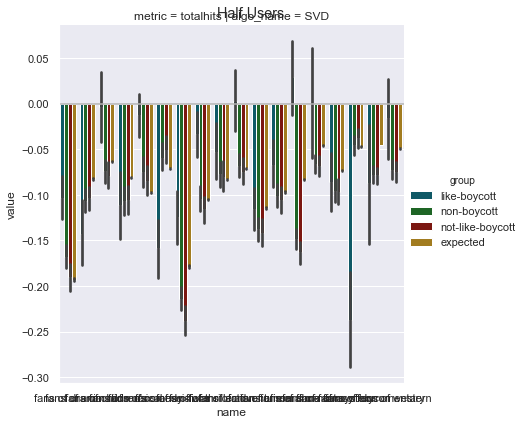

In [46]:
(total, total_sig, total_less, total_more, total_lbless), (diffs, ratios, vals) = plot_all_three_scenarios(genre_boycotts)
running_totals['total'] += total
running_totals['total_sig'] += total_sig
running_totals['total_less'] += total_less
running_totals['total_more'] += total_more
running_totals['total_lbless'] += total_lbless

for key in all_diffs.keys():
    all_diffs[key].update(diffs[key])
    all_ratios[key].update(ratios[key])
    
for key in all_vals.keys():
    all_vals[key].update(vals[key])

plt.show()

In [47]:
running_totals

{'total': 50,
 'total_lbless': 41,
 'total_less': 35,
 'total_more': 15,
 'total_sig': 36}

In [48]:
from pprint import pprint
# pprint(all_diffs)
# pprint(all_ratios)
pprint(all_vals)

{'lb': {'18-24': -0.37875222766380806,
        '25-34': -0.38471230191180583,
        '35-44': -0.26742741402177667,
        '45-49': -0.11853317118665004,
        '50-55': -0.03988567514445787,
        '56+': -0.17519019696330237,
        'academic/educator': -0.07404535680560889,
        'artist': 0.19993156614062438,
        'bottom 10% contributors': 0.07723871739637103,
        'clerical/admin': -0.01164848185902334,
        'college/grad student': -0.2140384450181299,
        'customer service': 0.034662932909379315,
        'doctor/health care': -0.020082126966588155,
        'executive/managerial': -0.0532046119603105,
        'fans of action': -0.05341243367828571,
        'fans of adventure': 0.0033253749708802268,
        'fans of animation': -0.14323429548435213,
        "fans of children's": -0.003716835187188788,
        'fans of comedy': -0.012798992923227146,
        'fans of crime': -0.11560662095223381,
        'fans of documentary': -0.08725856620796262,
        'fan

In [49]:
with open('all_ratios.json', 'w') as f:
    json.dump(all_ratios, f)
with open('all_diffs.json', 'w') as f:
    json.dump(all_diffs, f)
with open('all_vals.json', 'w') as f:
    json.dump(all_vals, f)

In [50]:
with open('some_distances.json', 'r') as f:
    group_to_group_to_vectype_to_distancetype_to_ = json.load(f)
    
row_dicts = []
for group, group_to_vectype_to_distancetype_to_ in group_to_group_to_vectype_to_distancetype_to_.items():
    if group == 'all':
        continue
    row_dict = {}
    row_dict['name'] = group
    for group2, vectype_to_distancetype_to_ in group_to_vectype_to_distancetype_to_.items():
        if group2 != 'all':
            continue
        for vectype, distancetype_to_ in vectype_to_distancetype_to_.items():
            for distancetype, val in distancetype_to_.items():
                row_dict['{}_{}'.format(vectype, distancetype)] = val
    row_dicts.append(row_dict)

df = pd.DataFrame(row_dicts)
df.name = [
    x.replace('excluded', '')
    .replace('users from', '')
    .replace('using threshold 4', '')
    .replace('Top 10% contributors', 'power users')
    .strip()
    .lower()
    for x in list(df.name)
]

In [51]:
with open('all_ratios.json', 'r') as f:
    all_ratios = json.load(f)
    
with open('all_diffs.json', 'r') as f:
    all_diffs = json.load(f)
    
with open('all_vals.json', 'r') as f:
    all_vals = json.load(f)
    
with open('group_to_num_ratings', 'r') as f:
    group_to_num_ratings = json.load(f)
temp_df = pd.DataFrame.from_dict(group_to_num_ratings, orient='index')
temp_df.index = [
    x.replace('excluded', '')
    .replace('users from', '')
    .replace('using threshold 4', '')
    .replace('Top 10% contributors', 'power users')
    .strip()
    .lower()
    for x in list(temp_df.index)
]
print(temp_df)
group_to_num_ratings = temp_df.to_dict()[0]


#print(group_to_num_ratings)    
lb_ratios = all_ratios['lb']
nb_ratios = all_ratios['nb']



row_dicts = []
for key, val in lb_ratios.items():
    row_dict = {
        'name': key,
        'like-boycott-ratio': val,
        'non-boycott-ratio': nb_ratios[key],
        'like-boycott-diff': all_diffs['lb'][key],
        'non-boycott-diff': all_diffs['lb'][key],
        'num_ratings': group_to_num_ratings[key],
        'like-boycott-val': all_vals['lb'][key],
        'not-like-val': all_vals['not-like'][key],
    }
    row_dicts.append(row_dict)
ratios_df = pd.DataFrame(row_dicts)

df = df.merge(right=ratios_df, on='name', how='inner')
print(df.head())

                               0
male users                753769
female users              246440
fans of drama             283280
fans of animation         123314
fans of children's         85744
fans of musical           120386
fans of comedy            150470
fans of sci-fi            101277
fans of war               268388
fans of thriller          164050
fans of action            124499
fans of adventure         102718
fans of crime             177567
fans of romance           149309
fans of film-noir         126151
fans of fantasy            45766
fans of mystery           106949
fans of horror             48464
fans of documentary        43364
fans of western            52250
under 18                   27211
18-24                     183536
25-34                     395556
35-44                     199003
45-49                      83633
50-55                      72490
56+                        38780
other                     130499
academic/educator          85351
artist    

In [52]:
names = {
    'name': 'Name', 'num_ratings': '# Ratings', 
    'like-boycott-ratio': 'Similar User Effect Ratio',
    'like-boycott-val':  '% change surfaced hits, similar users',
    'not-like-val':  '% change surfaced hits, other users',
}

table_df = df[['name', 'num_ratings', 'like-boycott-val', 'not-like-val', 'like-boycott-ratio']][
        df.name.isin([
        'male users', 'female users', 'power users',
        'fans of drama', 'fans of horror', 
        '25-34', '56+', 'under 18',
        'lawyer', 
        #'scientist', 
        'artist',
    ])
    #df.num_ratings > 150000
].rename(index=str, columns=names)

print(table_df)

              Name  # Ratings  % change surfaced hits, similar users  \
0       male users     753769                              -0.709094   
1     female users     246440                              -0.378508   
2    fans of drama     283280                              -0.102982   
17  fans of horror      48464                              -0.236981   
20        under 18      27211                              -0.265285   
22           25-34     395556                              -0.384712   
26             56+      38780                              -0.175190   
29          artist      50068                               0.199932   
38          lawyer      20563                              -0.181403   
42       scientist      22951                               0.031836   
48     power users     381407                              -0.760670   

    % change surfaced hits, other users  Similar User Effect Ratio  
0                             -0.641563                   1.105260

In [53]:
html = table_df.to_html(
    index=False,
    float_format='%.2f',
    columns=[
        'Name', '# Ratings', 
        names['like-boycott-val'],
        names['not-like-val'],
        'Similar User Effect Ratio'
]
)
css = """
<style>
body {column-count: 1 !important;}
table {
    width: 3in; height:3in;
        font-size: 9pt;
}
td {
    border: 1px solid;
}
th, td, table {
    border-left: none;
    border-right: none;
    padding-left: 10px;
}

</style>
"""

with open('table.html', 'w') as f:
    f.write('<link rel="stylesheet" href="pubcss-acm-sigchi.css">' + css + html)

len, std, mean 50 127913.06553873063 113407.62


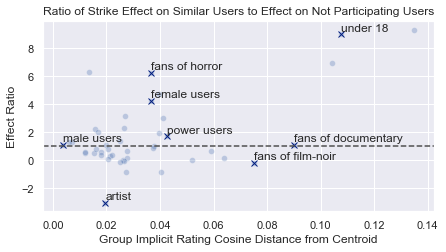

(0.5681608039016447, 5.747359366248717e-05)
    implicit_cosine  num_ratings  like-boycott-ratio                  name
0          0.003839       753769            1.105260            male users
27         0.005867       130499            1.314251                 other
22         0.007190       395556            1.284915                 25-34
8          0.011929       268388            0.522446           fans of war
34         0.012163       105425            0.580896  executive/managerial
41         0.013496        49109            6.327697       sales/marketing
2          0.015235       283280            0.540709         fans of drama
23         0.015831       199003            2.237831                 35-44
12         0.015984       177567            0.817380         fans of crime
43         0.016867        46021            2.051656         self-employed
33         0.017846        37205            0.358967    doctor/health care
13         0.017868       149309            0.635285    

In [54]:
# Implicit Cosine vs. LB Ratio
sns.set(style="darkgrid")
sns.set_color_codes("dark")

fig, ax = plt.subplots(1,1, figsize=(7, 3.5))
filtered = df[df.num_ratings >= 20000]
print('len, std, mean', len(df.num_ratings), np.std(df.num_ratings), np.mean(df.num_ratings))
#filtered = df

y = 'like-boycott-ratio'

sns.scatterplot(
    x='implicit_cosine', y=y, data=filtered,
    ax=ax, 
    #marker=".", 
    #line_kws={'alpha':.3},
    alpha=0.3
)

def label_point(x, y, val, ax, names):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        if str(point['val']) in names:
            ax.text(
                point['x'], point['y']+0.2, str(point['val']), 
            )
            ax.plot(point['x'], point['y'], 'bx')

label_point(
    filtered.implicit_cosine, filtered[y], filtered.name, plt.gca(),
    names=[
        'male users', 'female users', 'fans of film-noir', 'power users', 'under 18', 'artist',
        'fans of documentary', 'fans of horror',]
)  

plt.xlabel('Group Implicit Rating Cosine Distance from Centroid')
plt.title('Ratio of Strike Effect on Similar Users to Effect on Not Participating Users')
plt.ylabel('Effect Ratio')

ax.axhline(1, color='0.3', linestyle='--')
plt.savefig('implicitcosine_vs_lbratio.png', bbox_inches='tight', dpi=300)
plt.show()
print(pearsonr(filtered['implicit_cosine'], filtered[y]))
print(filtered[['implicit_cosine', 'num_ratings', y, 'name']].sort_values('implicit_cosine'))

# Back of the napkin

In [55]:

# non-boycott
# {'30_1m': -23.058666562695052, '30_20m': -2.8121875718078724}
# all
# {'30_1m': -49.3478951742734, '30_20m': -34.76984903171993}
boycott_size =0.3

strike_effects = {
    '1m': 0.493,
    '20m': 0.348,
}

boycott_effects = {
    '1m': 0.23,
    '20m': 0.028,
}
views_from_rec = 0.3

total_effects = {
    'strike': {},
    'boycott': {},
    'ratio': {},
}

# ds for dataset!
for ds in ['1m', '20m']:
    total_effects['boycott'][ds] = (1 - boycott_size) * boycott_effects[ds] * views_from_rec + boycott_size
    total_effects['strike'][ds] = 1 * strike_effects[ds] * views_from_rec
    total_effects['ratio'][ds] = total_effects['boycott'][ds] / total_effects['strike'][ds]


from pprint import pprint
pprint(total_effects)

{'boycott': {'1m': 0.3483, '20m': 0.30588},
 'ratio': {'1m': 2.3549695740365113, '20m': 2.9298850574712643},
 'strike': {'1m': 0.1479, '20m': 0.10439999999999999}}
